# Cap tube rise

In the previous notebook we dealt with some scaling issues preventing dynamic visualisation of our capillary rise case, this was partially fixed, we now write the dynamic visualisation so that we can debug the subsequent test case models faster.




Test case based on the experiment by Lunowa et al. (2022) _Dynamic Effects during the Capillary Rise of Fluids in Cylindrical Tubes_. 

In [1]:
import numpy as np
import math
import collections
from scipy.spatial import HalfspaceIntersection
from scipy.spatial import Delaunay
import matplotlib.pyplot as plt
#import polyscope as ps

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d
from ipywidgets import *
from matplotlib.widgets import Slider
from lsm import HNdC_ijk

# ddg imports
import os, sys
module_path = os.path.abspath(os.path.join('../../../ddgclib'))
if module_path not in sys.path:
    sys.path.append(module_path)
from ddgclib._complex import Complex
from ddgclib import *
from ddgclib._complex import *
from ddgclib._curvatures import * #plot_surface#, curvature
from ddgclib._capillary_rise_flow import * #plot_surface#, curvature
from ddgclib._hyperboloid import *
from ddgclib._catenoid import *
from ddgclib._ellipsoid import *
from ddgclib._eos import *
from ddgclib._misc import *
from ddgclib._plotting import *
from ddgclib._sphere import *

## Imports and physical parameters
# std library
import numpy as np
import scipy

# plotting
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# ddg imports
# Allow for relative imports from main library:
import os
import sys
module_path = os.path.abspath(os.path.join('../../../ddgclib'))
if module_path not in sys.path:
    sys.path.append(module_path)

from ddgclib import *
#from ddgclib._case1 import *
from ddgclib._complex import *
from ddgclib._curvatures import * #plot_surface#, curvature
from ddgclib._capillary_rise_flow import * #plot_surface#, curvature
from ddgclib._capillary_rise import * #plot_surface#, curvature
from ddgclib._eos import *
from ddgclib._misc import *
from ddgclib._plotting import *

# compute duals (and Delaunay dual from a set of points)
from barycentric._duals import compute_vd, _merge_local_duals_vector, triang_dual, plot_dual

# Plots
from barycentric._duals import  plot_dual_mesh_2D, plot_dual_mesh_3D

# Geometry and dual computations
from barycentric._duals import area_of_polygon, e_star, volume_of_geometric_object, plot_dual, v_star

# Boundary geometry
from barycentric._duals import  _set_boundary, _find_plane_equation, _find_intersection, _reflect_vertex_over_edge

# Area computations
from barycentric._duals import d_area

# Volume computations (including helper functions)
from barycentric._duals import _signed_volume_parallelepiped, _volume_parallelepiped
# DDG gradient operations on primary edges (for continuum)
from barycentric._duals import dP, du, dudt

def incom_Poi(domain, refinements=2):
    """
    Compute the triangulate of a 2D incompressible Poiseuile flow
    """
    HC = Complex(2, domain)
    HC.triangulate()
    for i in range(refinements):
        HC.refine_all()

    points = []
    for v in HC.V:
        points.append(v.x_a)
    points = np.array(points, dtype='float64')
    tri = Delaunay(points)
    return points


def plot_complex_3d_mat(points):
    import numpy as np
    import matplotlib.pyplot as plt
    from mpl_toolkits.mplot3d import Axes3D
    from scipy.spatial import Delaunay

    #np.random.seed(180)
    #points = np.random.rand(10, 3)

    tri = Delaunay(points)

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(points[:, 0], points[:, 1], points[:, 2])

    colors = plt.cm.tab20(np.linspace(0, 1, len(tri.simplices)))

    for i, s in enumerate(tri.simplices):
        tetrahedron = points[s]
        facets = [[tetrahedron[0], tetrahedron[1], tetrahedron[2]],
                  [tetrahedron[0], tetrahedron[1], tetrahedron[3]],
                  [tetrahedron[0], tetrahedron[2], tetrahedron[3]],
                  [tetrahedron[1], tetrahedron[2], tetrahedron[3]]]
        collection = Poly3DCollection(facets, alpha=0.1)
        face_color = colors[i]
        collection.set_facecolor(face_color)
        edge_color = (1, 1, 1)  # Make edges less visible
        collection.set_edgecolor(edge_color)
        ax.add_collection3d(collection)

        # Plot edges
        edges = [[tetrahedron[0], tetrahedron[1]],
                 [tetrahedron[0], tetrahedron[2]],
                 [tetrahedron[0], tetrahedron[3]],
                 [tetrahedron[1], tetrahedron[2]],
                 [tetrahedron[1], tetrahedron[3]],
                 [tetrahedron[2], tetrahedron[3]]]
        for edge in edges:
            ax.plot3D(*zip(edge[0], edge[1]), color='k', linewidth=0.5)



ModuleNotFoundError: No module named 'lsm'

# 2D

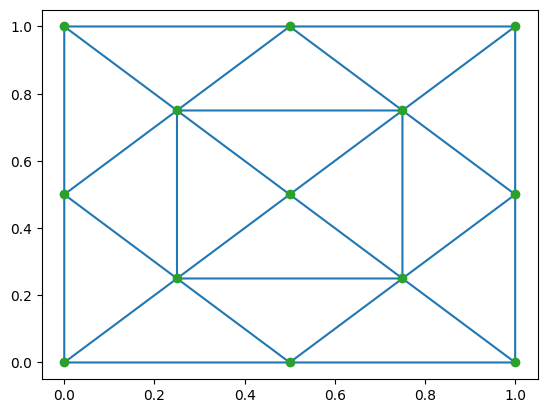

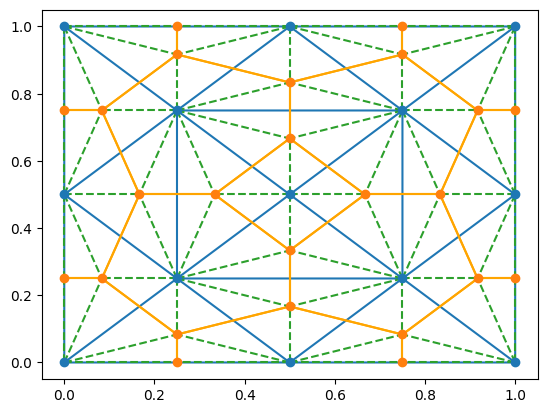

In [2]:
#NOTE: This was moved after defining the code below to validate the 2D:
domain = [(0, 1),]*2

points = incom_Poi(domain, refinements=1)
HC, tri = triang_dual(points, plot_delaunay=True)
#HC.dim = 2
# NEW: Compute boundaries
bV = set()
for v in HC.V:
    if ((v.x_a[0] == 0.0 or v.x_a[1] == 0.0) or
        (v.x_a[0] == 1.0 or v.x_a[1] == 1.0)):
        bV.add(v)
        
for bv in bV:
    _set_boundary(bv)
    
# Now compute duals as normal   
compute_vd(HC, cdist =1e-10)

plot_dual_mesh_2D(HC, tri, points)

# 3 D


From the paper we expect to reach equilibrium after ∼0.05 s when using the parameters defined in the next cell:

In [3]:
r_list = np.array([0.375, 0.5, 0.65]) * 1e-3  # m, Tube radii for 3 experiments
#r = 0.5#e-3  # mm (not m!), Default tube radius
r = r_list[1]  # mm (not m!), Default tube radius

gamma = 0.0728  # N/m, surface tension of water at 20 deg C
mu = 0.001  # Pa s, viscosity
rho = 997  # kg/m3, density

g = 9.81  # m/s2
# Parameters from EoS:
T_0 = 273.15 + 25  # K, initial tmeperature
P_0 = 101.325  # kPa, ambient pressure
#gamma = IAPWS(T_0)  # N/m, surface tension of water at 20 deg C
theta_p = 9.99* np.pi/180.0  # Three-phase contact angle (degrees immediately converted to radius

# Initial condition
theta_i = 0#2*np.pi  #TODO: Doesn't really do anything yet unless equilibrium is set to True

# Jurin equilibrium height in m:
h_jurin = 2 * gamma * np.cos(theta_p) / (rho * g * r)
r*1e3, h_jurin *1e3

(0.5, 29.321894204747586)

NOTE: From the paper we expect a rise time is roughly 0.3 s

The initial condition is atmospheric pressure at the bottom of the tube (assume the tube is "instantly" inserted and appears below the water line)

The rest of the pressure initial condition should follow rho g h increase.

Different boundary conditions will be explored.

In [4]:
def _cap_rise_meniscus_init(r, theta_i, gamma, N=4, refinement=0,
                            cdist=1e-10, equilibrium=True):
    """
    Helper function to generate the initial film
    :param r: 
    :param theta_i: 
    :param gamma: 
    :param N: 
    :param refinement: 
    :return: 
    """
    Theta = np.linspace(0.0, 2 * np.pi, N)  # range of theta
    R = r / np.cos(theta_i)  # = R at theta = 0
    # Exact values:
    K_f = (1 / R) ** 2
    H_f = 1 / R + 1 / R  # 2 / R
    dp_exact = gamma * (2 / R)  # Pa      # Young-Laplace equation  dp = - gamma * H_f = - gamma * (1/R1 + 1/R2)
    F = []
    nn = []
    F.append(np.array([0.0, 0.0, R * np.sin(theta_i) - R]))
    nn.append([])
    ind = 0
    for theta in Theta:
        ind += 1
        # Define coordinates:
        # x, y, z = sphere(R, theta, phi)
        F.append(np.array([r * np.sin(theta), r * np.cos(theta), 0.0]))
        # Define connections:
        nn.append([])
        if ind > 0:
            nn[0].append(ind)
            nn[ind].append(0)
            nn[ind].append(ind - 1)
            nn[ind].append((ind + 1) % N)

    # clean F
    for f in F:
        for i, fx in enumerate(f):
            if abs(fx) < 1e-15:
                f[i] = 0.0

    F = np.array(F)
    nn[1][1] = ind

    # Construct complex from the initial geometry:
    HC = construct_HC(F, nn)
    v0 = HC.V[tuple(F[0])]
    # Compute boundary vertices
    V = set()
    for v in HC.V:
        V.add(v)
    bV = V - set([v0])
    for i in range(refinement):
        V = set()
        for v in HC.V:
            V.add(v)
        HC.refine_all_star(exclude=bV)
        # New boundary vertices:
        for v in HC.V:
            if v.x[2] == 0.0:
                bV.add(v)

    # Move to spherical cap
    for v in HC.V:
        z = v.x_a[2]
        z_sphere = z - R * np.sin(theta_i)  # move to origin
        # z_sphere = R * np.cos(phi)  # For a sphere centered at origin
        phi_v = np.arccos(z_sphere/R)
        plane_dist = R * np.sin(phi_v)
        # Push vertices on the z-slice the required distance
        z_axis = np.array([0.0, 0.0, z])  # axial centre
        vec = v.x_a - z_axis
        s = np.abs(np.linalg.norm(vec) - plane_dist)
        nvec = normalized(vec)[0]
        nvec = v.x_a + s * nvec
        HC.V.move(v, tuple(nvec))
        vec = nvec - z_axis
        np.linalg.norm(vec)

    # Rebuild set after moved vertices (appears to be needed)
    bV = set()
    for v in HC.V:
        if v.x[2] == 0.0:
            bV.add(v)

    if not equilibrium:
        # Move to zero, for mean flow simulations
        VA = []
        for v in HC.V:
            if v in bV:
                continue
            else:
                VA.append(v.x_a)

        VA = np.array(VA)
        for i, v_a in enumerate(VA):
            v = HC.V[tuple(v_a)]
            v_new = tuple(v.x_a - np.array([0.0, 0.0, v.x_a[2]]))
            HC.V.move(v, v_new)


    return F, nn, HC, bV, K_f, H_f


def cap_rise_init_dyn(r, theta_i, gamma, N=4, refinement=0, depth_dist=0.06, depth_ref=3, cdist=1e-12,
                    equilibrium=True):
    """
    
    :param r: 
    :param theta_i: Initial angle
    :param gamma: 
    :param N: 
    :param refinement: 
    :param cdist: 
    :param equilibrium: 
    :return: 
    """
    F, nn, HC, bV, K_f, H_f = _cap_rise_meniscus_init(r, theta_i, gamma, N, refinement, cdist=1e-12, equilibrium=False)
    
    # Save the points and boundary points
    V_points = []
    bV_points = []
    for v in HC.V:
        V_points.append(v.x_a)
    
    for bv in bV:
        print(f'bv.x_a = {bv.x_a}')
        bV_points.append(bv.x_a)
    
    V_points_film = np.array(V_points)
    bV_points_film = np.array(bV_points)
    print(f'V_points_film.shape = {V_points_film.shape}')
    print(f'bV_points_film.shape = {bV_points_film.shape}')
    # Extend the meniscus film down to a tube below the water line:
    dx = depth_dist/depth_ref
    h = 0  # Height layer tracker
    for i in range(depth_ref):
        # Add new points
        for v in V_points_film:
            v_new = copy.copy(v)
            v_new[2] = v_new[2] + h
            V_points.append(v_new)
            
        # Track new boundary points 
        for bv in bV_points_film:
            bv_new = copy.copy(bv)
            bv_new[2] = bv_new[2] + h
            bV_points.append(bv_new)
            
        h -= dx  # Update next layer height
        
    V_points = np.array(V_points)
    bV_points_a = np.array(bV_points)
    
    # Reconstruct the complex using these values:
    HC = Complex(3)
    for va in V_points:
        v = HC.V[tuple(va)]
        # Set default boundary off
        v.boundary = False

    
    tri = Delaunay(V_points)
    plot_complex_3d_mat(V_points)
    for t in tri.simplices:
        for v1i in t:
            v1a = V_points[v1i]
            v1 = HC.V[tuple(v1a)]
            for v2i in t:
                v2a =  V_points[v2i]
                v2 = HC.V[tuple(v2a)]
                v1.connect(v2)
    
    # Add boundary conditions:
    if 0:
        for vba in bV_points_a:
            vb = HC.V[tuple(vba)]
            vb.boundary = True
        
        # All the top and bottom points must also be boundary points (in the future use boundary function):
    
        h += dx  # Reset height to last layer in loop
        for v in V_points_film:
            v_new = copy.copy(v)
            v1 = HC.V[tuple(v_new)]
            v1.boundary = True
            v_new[2] = v_new[2] + h
            v2 = HC.V[tuple(v_new)]
            v2.boundary = True
            bV_points.append(v1.x_a)
            bV_points.append(v2.x_a)
    
        bV_points = np.array(bV_points)
        print(f'V_points.shape = {V_points.shape}')
        print(f'bV_points.shape = {bV_points.shape}')
    
    # Clean up:
    HC.V.merge_all(cdist)
    
    bV = set()
    for vba in bV_points:
        vb = HC.V[tuple(vba)]
        bV.add(vb)
    print(f'bV = {bV}')
    return HC, bV


def cube_to_tube(r, refinements=1, height=5e-3):
    # Construct the initial cube 
    lb = -0.5
    ub = 0.5
    domain = [(lb, ub),]*3
    #symmetry = [0, 1, 1]
    HC = Complex(3, domain=domain, symmetry=None)
    HC.triangulate()
    for i in range(refinements):
        HC.refine_all()
    
    # NEW
    # Compute boundaries
    bV = set()
    for v in HC.V:
        if ((v.x_a[0] == lb or v.x_a[1] == lb or v.x_a[2] == lb) or
            (v.x_a[0] == ub or v.x_a[1] == ub or v.x_a[2] == ub)):
            bV.add(v)
            
    # boundaries which exclude the interior vertices on the top/bottom of
    # the cyllinder
    bV_sides = set()
    for v in HC.V:
        #if ((v.x_a[0] == lb or v.x_a[0] == ub) and
        #    (v.x_a[1] == lb or v.x_a[1] == ub)):
        if ((v.x_a[0] == lb or v.x_a[0] == ub) or
            (v.x_a[1] == lb or v.x_a[1] == ub)):
            bV_sides.add(v)
            # Special side boundary property
            v.side_boundary = True
        else:
            v.side_boundary = False
    #print(f'bV_sides = {bV_sides}')
    
    for bv in bV:
        _set_boundary(bv, True)
    for v in HC.V:
        if not (v in bV):
            _set_boundary(v, False)

    #for bv in bV:
    #    print(f'bv = {bv.x}')
    # Move the vertices to the tube radius
    for v in bV_sides:
        r_eff = r  # Trancated radius projection   
        nv = np.zeros(3)
        theta = math.atan2(v.x_a[1], v.x_a[0])
        nv[0] = r_eff * np.cos(theta)
        nv[1] = r_eff * np.sin(theta)
        if 1:
            h_eff = height #* ((1 - np.cos(np.pi * v.x[2]**0.5)) / 2)
        nv[2] = h_eff * (v.x[2] - 0.5) #* 1e-3
        print(f'nv[2] = {nv[2]}')
        HC.V.move(v, tuple(nv))
    
    for v in HC.V:
        #if v.boundary:
        if v.side_boundary:
            continue
        d = np.linalg.norm(v.x_a[:2])  # This is already a normalized distance for 0.5 bounds
        # Power law scaling:
        if 0:
            n = 0.5 # 0.6  # Aribtrarily chosen power law scaling, should be n<=r 
            r_eff = d**n * r  # Trancated radius projection   
        # log law scaling:
        if 0:
             r_eff = r * (np.log(d + 1) / np.log(2))
        # Sinusoidal scaling:
        if 1:
            r_eff = (r * ((1 - np.cos(np.pi * d**0.5)) / 2))
            
        #r_eff = r/d  # Trancated radius projection   
        nv = np.zeros(3)
        theta = math.atan2(v.x_a[1], v.x_a[0])
        nv[0] = r_eff * np.cos(theta)
        nv[1] = r_eff * np.sin(theta)
        # Height scaling
        if 1:
            h_eff = height #* ((1 - np.cos(np.pi * v.x[2]**0.5)) / 2)
            
            
        nv[2] = h_eff * (v.x[2] - 0.5) #* 1e-3
        print(f'nv[2] = {nv[2]}')
        HC.V.move(v, tuple(nv))
        
    #print(f'post move:')
    #for bv in bV:
    #    print(f'bv = {bv.x}')
    return HC

In [5]:
r, r * 0.5e1

(0.0005, 0.0025)

In [6]:
ps.remove_all_structures()

In [7]:
# Initiation
%matplotlib notebook
import polyscope as ps
if 0:
    r = 0.5
 
height = r * 0.5e1
#height = 0.5
HC = cube_to_tube(r, refinements=1, height=height)

#HC.plot_complex()

# Compute the initial duals
compute_vd(HC, cdist=1e-8)

# Plot the initial complex
if 1:
    #vi = HC.V[(0.0, 0.0, 0.0)]
    #vi = HC.V[(0.5, 0.0, 0.0)]  # Vertex No. 17
    vi = HC.V[(0.5e-3, 0.0, 0.0)]  # Vertex No. 17
    #vi = HC.V[(0.3535533905932738, 0.35355339059327373, 0.5)]
    print(f'vi.x = {vi.x}')
    #plot_dual(vi, HC, length_scale=1e3, point_radii=1e-5)
    length_scale = 1e-3
    plot_dual(vi, HC, length_scale=length_scale, 
                      point_radii=1e-5)
    ps.look_at((0., -10.*length_scale, 0.), (0., 0., 0.))  # Side
    ps.look_at((0., -10.*length_scale, 2.*length_scale), (0., 0., 0.))  # Side raise
    #ps.show()
    #ps.remove_surface_mesh("Dual face")
    ps.remove_all_structures()


nv[2] = -0.0025
nv[2] = 0.0
nv[2] = -0.00125
nv[2] = -0.00125
nv[2] = -0.0025
nv[2] = -0.0025
nv[2] = -0.00125
nv[2] = 0.0
nv[2] = 0.0
nv[2] = -0.0025
nv[2] = -0.00125
nv[2] = 0.0
nv[2] = -0.0025
nv[2] = 0.0
nv[2] = -0.00125
nv[2] = -0.00125
nv[2] = -0.0025
nv[2] = 0.0
nv[2] = -0.0025
nv[2] = -0.00125
nv[2] = 0.0
nv[2] = -0.0025
nv[2] = 0.0
nv[2] = -0.00125
nv[2] = -0.00125
nv[2] = -0.0025
nv[2] = 0.0
nv[2] = -0.001875
nv[2] = -0.000625
nv[2] = -0.001875
nv[2] = -0.000625
nv[2] = -0.001875
nv[2] = -0.001875
nv[2] = -0.000625
nv[2] = -0.000625
vi.x = (0.0005, 0.0, 0.0)
[polyscope] Backend: openGL3_glfw -- Loaded openGL version: 3.3.0 NVIDIA 580.82.07
verts = [[ 2.50000000e-04  0.00000000e+00  0.00000000e+00]
 [ 2.84517797e-04  1.17851130e-04  0.00000000e+00]
 [ 2.70524772e-04  1.45524772e-04 -1.56250000e-04]
 [ 1.82136424e-04  5.71364241e-05 -4.68750000e-04]
 [ 1.82136424e-04 -5.71364241e-05 -4.68750000e-04]
 [ 2.70524772e-04 -1.45524772e-04 -1.56250000e-04]
 [ 2.84517797e-04 -1.1785113

In [8]:
# Move some vertices:
if 1: # Turn off for testing
    vi = HC.V[(0.0, 0.0, 0.0)]
    #vi = HC.V[(0.3535533905932738, 0.35355339059327373, 0.5)]
    vt_new = (0.0, 0.0, (0.5 + 2e-1)*1e-3)
    v_new = HC.V.move(vi, vt_new)
    vi = v_new 
    
    # Postprocessing
    HC.V.merge_all(1e-12)
    # Clear the dual cache
    for v in HC.V:
        v.vd = set()
      
    HcVd = copy.copy(HC.Vd)
    for vd in HcVd:
        HC.Vd.cache.pop(vd.x)
    
    # Recompute the dual:
    compute_vd(HC, cdist=1e-7)
        
    # Plot the final complex
    if 1:
        plot_dual(vi, HC, length_scale=length_scale, 
                      point_radii=1e-5)
        ps.look_at((0., -10.*length_scale, 0.), (0., 0., 0.))  # Side
        ps.look_at((0., -10.*length_scale, 2.*length_scale), (0., 0., 0.))  #

        #ps.show()
        #ps.remove_surface_mesh("Dual face")
        ps.remove_all_structures()
        

verts = [[-1.76776695e-04 -1.76776695e-04  3.50000000e-04]
 [-2.84517797e-04 -1.17851130e-04  2.33333333e-04]
 [-2.70524772e-04 -1.45524772e-04  1.87500000e-05]
 [-1.45524772e-04 -2.70524772e-04  1.87500000e-05]
 [-1.17851130e-04 -2.84517797e-04  2.33333333e-04]
 [ 1.53080850e-20 -2.50000000e-04  3.50000000e-04]
 [ 1.17851130e-04 -2.84517797e-04  2.33333333e-04]
 [ 1.45524772e-04 -2.70524772e-04  1.87500000e-05]
 [ 5.71364241e-05 -1.82136424e-04 -2.93750000e-04]
 [-5.71364241e-05 -1.82136424e-04 -2.93750000e-04]
 [-1.14272848e-04 -1.14272848e-04  3.75000000e-05]
 [-1.82136424e-04 -5.71364241e-05 -2.93750000e-04]
 [ 1.53080850e-20  2.50000000e-04  3.50000000e-04]
 [-1.17851130e-04  2.84517797e-04  2.33333333e-04]
 [-1.45524772e-04  2.70524772e-04  1.87500000e-05]
 [-5.71364241e-05  1.82136424e-04 -2.93750000e-04]
 [ 5.71364241e-05  1.82136424e-04 -2.93750000e-04]
 [ 1.45524772e-04  2.70524772e-04  1.87500000e-05]
 [ 1.17851130e-04  2.84517797e-04  2.33333333e-04]
 [ 2.50000000e-04  0.00

# Energy minimisation approach
## Sparse

In [9]:
import polyscope as ps

t_final = 10

# Polysope parameters:
length_scale = 1e-3
# Initiate refinement:
HC = cube_to_tube(r, refinements=1, height=height)
# Compute the initial duals
compute_vd(HC, cdist=1e-8)
# Select a vertex to monitor:
#vi = HC.V[(0.5*length_scale, 0.0, 0.0)]  # Vertex No. 17
vi = HC.V[(0.0, 0.0, 0.0)]  # Vertex No. 17


# Initial plot:
ps.init()
if 1:
    plot_dual(vi, HC, length_scale=1e3, point_radii=1e-5)
    ps.look_at((0., -10.*length_scale, 2.*length_scale), (0., 0., 0.))  # Side raise
    #ps.look_at((1., -8., -8.), (0., 0., 0.))
   # ps.look_at((-6.0, 0.0, 2.0), (0., 0., 0.))
   # ps.show()
# Dynamic loop
t = 0
i = 0  
menv = False
#while(not ps.window_requests_close()):
while(t < t_final):
    # Move all vertices on boundary
    for v in HC.V:      
        if t < 0.2:
            if v.x_a[2] < 0.0:
                continue
        if v.x_a.all() == vi.x_a.all():
            menv = True
            
        # Distance from centre
        #v_xz = np.array([v.x_a[0], v.x_a[2]])
        v_xz = np.array([v.x_a[0], v.x_a[1]])
        d = np.linalg.norm(v_xz - np.array([0, 0]))
        #print(f'np.abs(d - r) < 1e-10: = {np.abs(d - r) < 1e-10}')
        if np.abs(d - r) < 1e-10:
            vt_new = v.x_a
            vt_new[2] += 0.2e-3*(h_jurin - vt_new[2])
            #vt_new[2] += 1e-5
            vt_new = tuple(vt_new)
            v_new = HC.V.move(v, vt_new)
        if menv:
            #vi = v_new  # TODO: needed?
            menv = False

    
    # Move special monitored vertex
    if 0:
        vt_new = vi.x_a
        vt_new[2] += 1e-5
        vt_new = tuple(vt_new)
        v_new = HC.V.move(vi, vt_new)
        vi = v_new 

    # Move all other vertices
        
    # Move interior vertices
    if t > 1:
        for v in HC.V:      
            if t < 0.2:
                if v.x_a[2] < 0.0:
                    continue
            # Distance from centre
            #v_xz = np.array([v.x_a[0], v.x_a[2]])
            v_xz = np.array([v.x_a[0], v.x_a[1]])
            d = np.linalg.norm(v_xz - np.array([0, 0]))
            #print(f'np.abs(d - r) < 1e-10: = {np.abs(d - r) < 1e-10}')
            if np.abs(d - r) < 1e-10:
                continue
            d += 1e-4
            vt_new = v.x_a
            vt_new[2] += 0.1e-3*(h_jurin - vt_new[2]) * (d/r)
            #vt_new[2] += 1e-5
            vt_new = tuple(vt_new)
            v_new = HC.V.move(v, vt_new)

    # Postprocessing
    HC.V.merge_all(1e-12)
    # Clear the dual cache
    for v in HC.V:
        v.vd = set()
      
    HcVd = copy.copy(HC.Vd)
    for vd in HcVd:
        HC.Vd.cache.pop(vd.x)
    
    # Recompute the dual:
    compute_vd(HC, cdist=1e-7)
    
    # Plot in polyscope and updaste the frame
    plot_dual(vi, HC, length_scale=length_scale, 
                      point_radii=1e-5)
    #ps.look_at((0., -10.*length_scale, 2.*length_scale), (0., 0., 0.))  # Side raise
    ps.look_at((0., -6.*length_scale, 2.*length_scale), (0., 0., 0.))  # Side raise
    ps.frame_tick() # renders one UI frame, returns immediately
    ps.screenshot(f"./fig/cap_rise/sparse_short/cap_rise_{i}.png")
    # Update the time step (TODO)
    t += 0.05
    #time.sleep(0.1)
    i += 1
    print(f't = {t}')
    if t > t_final:  # Break the while loop at the end
        ps.window_requests_close()
        break
        


nv[2] = -0.0025
nv[2] = 0.0
nv[2] = -0.00125
nv[2] = -0.00125
nv[2] = -0.0025
nv[2] = -0.0025
nv[2] = -0.00125
nv[2] = 0.0
nv[2] = 0.0
nv[2] = -0.0025
nv[2] = -0.00125
nv[2] = 0.0
nv[2] = -0.0025
nv[2] = 0.0
nv[2] = -0.00125
nv[2] = -0.00125
nv[2] = -0.0025
nv[2] = 0.0
nv[2] = -0.0025
nv[2] = -0.00125
nv[2] = 0.0
nv[2] = -0.0025
nv[2] = 0.0
nv[2] = -0.00125
nv[2] = -0.00125
nv[2] = -0.0025
nv[2] = 0.0
nv[2] = -0.001875
nv[2] = -0.000625
nv[2] = -0.001875
nv[2] = -0.000625
nv[2] = -0.001875
nv[2] = -0.001875
nv[2] = -0.000625
nv[2] = -0.000625
verts = [[ 1.53080850e-20 -2.50000000e-04  0.00000000e+00]
 [-1.17851130e-04 -2.84517797e-04  0.00000000e+00]
 [-1.45524772e-04 -2.70524772e-04 -1.56250000e-04]
 [-5.71364241e-05 -1.82136424e-04 -4.68750000e-04]
 [ 5.71364241e-05 -1.82136424e-04 -4.68750000e-04]
 [ 1.45524772e-04 -2.70524772e-04 -1.56250000e-04]
 [ 1.17851130e-04 -2.84517797e-04  0.00000000e+00]
 [-1.76776695e-04 -1.76776695e-04  0.00000000e+00]
 [-2.70524772e-04 -1.45524772e-04 -

In [10]:
1e-3*(h_jurin - vt_new[2])

2.9494072995810799374e-05

# Medium refinement

In [11]:
import polyscope as ps


# Polysope parameters:
length_scale = 1e-3
# Initiate refinement:
HC = cube_to_tube(r, refinements=2, height=height)
# Compute the initial duals
compute_vd(HC, cdist=1e-8)
# Select a vertex to monitor:
#vi = HC.V[(0.5*length_scale, 0.0, 0.0)]  # Vertex No. 17
vi = HC.V[(0.0, 0.0, 0.0)]  # Vertex No. 17


# Initial plot:
ps.init()
if 1:
    plot_dual(vi, HC, length_scale=1e3, point_radii=1e-5)
    ps.look_at((0., -10.*length_scale, 2.*length_scale), (0., 0., 0.))  # Side raise
    #ps.look_at((1., -8., -8.), (0., 0., 0.))
   # ps.look_at((-6.0, 0.0, 2.0), (0., 0., 0.))
   # ps.show()
# Dynamic loop
t = 0
i = 0  
menv = False
#while(not ps.window_requests_close()):
while(t < t_final):
    # Move all vertices on boundary
    for v in HC.V:      
        if t < 0.2:
            if v.x_a[2] < 0.0:
                continue
        if v.x_a.all() == vi.x_a.all():
            menv = True
            
        # Distance from centre
        #v_xz = np.array([v.x_a[0], v.x_a[2]])
        v_xz = np.array([v.x_a[0], v.x_a[1]])
        d = np.linalg.norm(v_xz - np.array([0, 0]))
        #print(f'np.abs(d - r) < 1e-10: = {np.abs(d - r) < 1e-10}')
        if np.abs(d - r) < 1e-10:
            vt_new = v.x_a
            vt_new[2] += 0.2e-3*(h_jurin - vt_new[2])
            #vt_new[2] += 1e-5
            vt_new = tuple(vt_new)
            v_new = HC.V.move(v, vt_new)
        if menv:
            #vi = v_new  # TODO: needed?
            menv = False

    
    # Move special monitored vertex
    if 0:
        vt_new = vi.x_a
        vt_new[2] += 1e-5
        vt_new = tuple(vt_new)
        v_new = HC.V.move(vi, vt_new)
        vi = v_new 
    
    # Move all other vertices
        
    # Move interior vertices
    if t > 1:
        for v in HC.V:      
            if t < 0.2:
                if v.x_a[2] < 0.0:
                    continue
            # Distance from centre
            #v_xz = np.array([v.x_a[0], v.x_a[2]])
            v_xz = np.array([v.x_a[0], v.x_a[1]])
            d = np.linalg.norm(v_xz - np.array([0, 0]))
            #print(f'np.abs(d - r) < 1e-10: = {np.abs(d - r) < 1e-10}')
            if np.abs(d - r) < 1e-10:
                continue
            d += 1e-4
            vt_new = v.x_a
            vt_new[2] += 0.1e-3*(h_jurin - vt_new[2]) * (d/r)
            #vt_new[2] += 1e-5
            vt_new = tuple(vt_new)
            v_new = HC.V.move(v, vt_new)

    # Postprocessing
    HC.V.merge_all(1e-12)
    # Clear the dual cache
    for v in HC.V:
        v.vd = set()
      
    HcVd = copy.copy(HC.Vd)
    for vd in HcVd:
        HC.Vd.cache.pop(vd.x)
    
    # Recompute the dual:
    compute_vd(HC, cdist=1e-7)
    
    # Plot in polyscope and updaste the frame
    plot_dual(vi, HC, length_scale=length_scale, 
                      point_radii=1e-5)
    #ps.look_at((0., -10.*length_scale, 2.*length_scale), (0., 0., 0.))  # Side raise
    ps.look_at((0., -6.*length_scale, 2.*length_scale), (0., 0., 0.))  # Side raise
    ps.frame_tick() # renders one UI frame, returns immediately
    ps.screenshot(f"./fig/cap_rise/medium_short/cap_rise_{i}.png")
    # Update the time step (TODO)
    t += 0.05
    #time.sleep(0.1)
    i += 1
    print(f't = {t}')
    if t > t_final:  # Break the while loop at the end
        ps.window_requests_close()
        break

nv[2] = -0.0025
nv[2] = 0.0
nv[2] = -0.00125
nv[2] = -0.001875
nv[2] = -0.000625
nv[2] = -0.0025
nv[2] = -0.001875
nv[2] = -0.00125
nv[2] = -0.000625
nv[2] = 0.0
nv[2] = 0.0
nv[2] = -0.0025
nv[2] = -0.001875
nv[2] = -0.00125
nv[2] = -0.000625
nv[2] = -0.0025
nv[2] = -0.001875
nv[2] = -0.00125
nv[2] = -0.000625
nv[2] = 0.0
nv[2] = -0.00125
nv[2] = -0.0025
nv[2] = -0.0025
nv[2] = -0.00125
nv[2] = 0.0
nv[2] = 0.0
nv[2] = -0.001875
nv[2] = -0.000625
nv[2] = -0.001875
nv[2] = -0.000625
nv[2] = -0.0025
nv[2] = -0.001875
nv[2] = -0.00125
nv[2] = -0.000625
nv[2] = 0.0
nv[2] = -0.00125
nv[2] = -0.0025
nv[2] = 0.0
nv[2] = -0.001875
nv[2] = -0.000625
nv[2] = -0.0025
nv[2] = -0.001875
nv[2] = -0.00125
nv[2] = -0.000625
nv[2] = 0.0
nv[2] = -0.0025
nv[2] = -0.001875
nv[2] = -0.00125
nv[2] = -0.000625
nv[2] = 0.0
nv[2] = -0.0025
nv[2] = -0.00125
nv[2] = 0.0
nv[2] = -0.001875
nv[2] = -0.000625
nv[2] = -0.0025
nv[2] = 0.0
nv[2] = -0.00125
nv[2] = -0.001875
nv[2] = -0.000625
nv[2] = -0.0025
nv[2] = -0.0

KeyboardInterrupt: 

# Fine

In [ ]:
import polyscope as ps

t_final = 35

# Polysope parameters:
length_scale = 1e-3
# Initiate refinement:
HC = cube_to_tube(r, refinements=3, height=height)
# Compute the initial duals
compute_vd(HC, cdist=1e-8)
# Select a vertex to monitor:
#vi = HC.V[(0.5*length_scale, 0.0, 0.0)]  # Vertex No. 17
vi = HC.V[(0.0, 0.0, 0.0)]  # Vertex No. 17



# Initial plot:
ps.init()
if 1:
    plot_dual(vi, HC, length_scale=1e3, point_radii=1e-5)
    ps.look_at((0., -10.*length_scale, 2.*length_scale), (0., 0., 0.))  # Side raise
    #ps.look_at((1., -8., -8.), (0., 0., 0.))
   # ps.look_at((-6.0, 0.0, 2.0), (0., 0., 0.))
   # ps.show()
# Dynamic loop
t = 0
i = 0
menv = False
#while(not ps.window_requests_close()):
while(t < t_final):
    # Move all vertices on boundary
    for v in HC.V:
        if t < 0.2:
            if v.x_a[2] < 0.0:
                continue
        if v.x_a.all() == vi.x_a.all():
            menv = True

        # Distance from centre
        #v_xz = np.array([v.x_a[0], v.x_a[2]])
        v_xz = np.array([v.x_a[0], v.x_a[1]])
        d = np.linalg.norm(v_xz - np.array([0, 0]))
        #print(f'np.abs(d - r) < 1e-10: = {np.abs(d - r) < 1e-10}')
        if np.abs(d - r) < 1e-10:
            vt_new = v.x_a
            vt_new[2] += 0.2e-3*(h_jurin - vt_new[2])
            #vt_new[2] += 1e-5
            vt_new = tuple(vt_new)
            v_new = HC.V.move(v, vt_new)
        if menv:
            #vi = v_new  # TODO: needed?
            menv = False


    # Move special monitored vertex
    if 0:
        vt_new = vi.x_a
        vt_new[2] += 1e-5
        vt_new = tuple(vt_new)
        v_new = HC.V.move(vi, vt_new)
        vi = v_new

    # Move all other vertices

    # Move interior vertices
    if t > 1:
        for v in HC.V:
            if t < 0.2:
                if v.x_a[2] < 0.0:
                    continue
            # Distance from centre
            #v_xz = np.array([v.x_a[0], v.x_a[2]])
            v_xz = np.array([v.x_a[0], v.x_a[1]])
            d = np.linalg.norm(v_xz - np.array([0, 0]))
            #print(f'np.abs(d - r) < 1e-10: = {np.abs(d - r) < 1e-10}')
            if np.abs(d - r) < 1e-10:
                continue
            d += 1e-4
            vt_new = v.x_a
            vt_new[2] += 0.1e-3*(h_jurin - vt_new[2]) * (d/r)
            #vt_new[2] += 1e-5
            vt_new = tuple(vt_new)
            v_new = HC.V.move(v, vt_new)

    # Postprocessing
    HC.V.merge_all(1e-12)
    # Clear the dual cache
    for v in HC.V:
        v.vd = set()

    HcVd = copy.copy(HC.Vd)
    for vd in HcVd:
        HC.Vd.cache.pop(vd.x)

    # Recompute the dual:
    compute_vd(HC, cdist=1e-7)

    # Plot in polyscope and updaste the frame
    plot_dual(vi, HC, length_scale=length_scale,
                      point_radii=1e-5)
    #ps.look_at((0., -10.*length_scale, 2.*length_scale), (0., 0., 0.))  # Side raise
    ps.look_at((0., -6.*length_scale, 2.*length_scale), (0., 0., 0.))  # Side raise
    ps.frame_tick() # renders one UI frame, returns immediately
    ps.screenshot(f"./fig/cap_rise/fine_short/cap_rise_{i}.png")
    # Update the time step (TODO)
    t += 0.05
    #time.sleep(0.1)
    i += 1
    print(f't = {t}')
    if t > t_final:  # Break the while loop at the end
        ps.window_requests_close()
        break


nv[2] = -0.0025
nv[2] = 0.0
nv[2] = -0.00125
nv[2] = -0.001875
nv[2] = -0.000625
nv[2] = -0.0015625
nv[2] = -0.0021875
nv[2] = -0.0021875
nv[2] = -0.0009375
nv[2] = -0.0009375
nv[2] = -0.0003125
nv[2] = 0.0
nv[2] = -0.0009375
nv[2] = -0.0025
nv[2] = -0.0021875
nv[2] = -0.001875
nv[2] = -0.0015625
nv[2] = -0.00125
nv[2] = -0.000625
nv[2] = -0.0003125
nv[2] = 0.0
nv[2] = -0.0009375
nv[2] = -0.001875
nv[2] = -0.0015625
nv[2] = -0.00125
nv[2] = -0.0025
nv[2] = -0.0021875
nv[2] = -0.000625
nv[2] = -0.0003125
nv[2] = 0.0
nv[2] = -0.0003125
nv[2] = -0.0025
nv[2] = -0.001875
nv[2] = -0.00125
nv[2] = -0.000625
nv[2] = 0.0
nv[2] = -0.0015625
nv[2] = 0.0
nv[2] = -0.0025
nv[2] = -0.001875
nv[2] = -0.00125
nv[2] = -0.000625
nv[2] = -0.0025
nv[2] = -0.0021875
nv[2] = -0.0021875
nv[2] = -0.001875
nv[2] = -0.0015625
nv[2] = -0.0025
nv[2] = -0.001875
nv[2] = -0.00125
nv[2] = -0.000625
nv[2] = 0.0
nv[2] = -0.0021875
nv[2] = -0.0015625
nv[2] = -0.0015625
nv[2] = -0.0003125
nv[2] = -0.0009375
nv[2] = -0.0

# Conclusion:

This appears to work as execpted now, but it is unforutnately very slow. cleaning breaking out of the while loop also doesn't seem to work without crashing.

In [ ]:
import polyscope as ps 
help(ps.window_requests_close)

In [ ]:
time.sleep(0.1)